## Greenhouse

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Load CSV file (Assuming 'data.csv' contains the greenhouse sensor values)
use_cols = ["created_at", "air_temperature", "relative_humidity", "co2_level", "illumination_intensity"]
data = pd.read_csv('/content/greenhouse.csv', usecols=use_cols, parse_dates=['created_at'])
data.set_index('created_at', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert data to tensors
class GreenhouseDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Hyperparameters
seq_length = 10  # Number of past time steps to consider
input_size = data.shape[1]
hidden_size = 64
num_layers = 2
output_size = input_size
batch_size = 32
epochs = 50

# Prepare dataset
dataset = GreenhouseDataset(data_scaled, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)  # Keep correct input shape
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.6f}')

# Save the trained model
torch.save(model.state_dict(), 'lstm_greenhouse_model.pth')

# Function to predict future values
def predict_future(model, data, future_steps=10):
    model.eval()
    data = torch.tensor(data[-seq_length:], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, seq_length, input_size)
    predictions = []
    with torch.no_grad():
        for _ in range(future_steps):
            pred = model(data)  # Removed .unsqueeze(1)
            predictions.append(pred.cpu().numpy())
            data = torch.cat((data[:, 1:, :], pred.unsqueeze(0)), dim=1)  # Adjusted shape handling
    return scaler.inverse_transform(np.array(predictions).squeeze())


# Predict next 10 timesteps
future_predictions = predict_future(model, data_scaled, future_steps=10)
print("Future Predictions:\n", future_predictions)


Epoch 1/50, Loss: 0.149600
Epoch 2/50, Loss: 0.101580
Epoch 3/50, Loss: 0.096363
Epoch 4/50, Loss: 0.093617
Epoch 5/50, Loss: 0.095982
Epoch 6/50, Loss: 0.091231
Epoch 7/50, Loss: 0.090963
Epoch 8/50, Loss: 0.089678
Epoch 9/50, Loss: 0.089659
Epoch 10/50, Loss: 0.089237
Epoch 11/50, Loss: 0.090573
Epoch 12/50, Loss: 0.090083
Epoch 13/50, Loss: 0.089738
Epoch 14/50, Loss: 0.090199
Epoch 15/50, Loss: 0.089813
Epoch 16/50, Loss: 0.089898
Epoch 17/50, Loss: 0.090096
Epoch 18/50, Loss: 0.091460
Epoch 19/50, Loss: 0.089998
Epoch 20/50, Loss: 0.090552
Epoch 21/50, Loss: 0.091015
Epoch 22/50, Loss: 0.090682
Epoch 23/50, Loss: 0.088773
Epoch 24/50, Loss: 0.090122
Epoch 25/50, Loss: 0.089785
Epoch 26/50, Loss: 0.089362
Epoch 27/50, Loss: 0.089670
Epoch 28/50, Loss: 0.088235
Epoch 29/50, Loss: 0.089720
Epoch 30/50, Loss: 0.089522
Epoch 31/50, Loss: 0.088669
Epoch 32/50, Loss: 0.089504
Epoch 33/50, Loss: 0.089678
Epoch 34/50, Loss: 0.089572
Epoch 35/50, Loss: 0.089416
Epoch 36/50, Loss: 0.089991
E

### With accuracies


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load CSV file
use_cols = ["created_at", "air_temperature", "relative_humidity", "co2_level", "illumination_intensity"]
data = pd.read_csv('/content/greenhouse.csv', usecols=use_cols, parse_dates=['created_at'])
data.set_index('created_at', inplace=True)

# Feature Engineering: Add rolling mean, std, and lag features
data['temp_mean'] = data['air_temperature'].rolling(window=5, min_periods=1).mean()
data['temp_std'] = data['air_temperature'].rolling(window=5, min_periods=1).std()

# Adding lag features (1, 3, 5 days)
for lag in [1, 3, 5]:
    for col in ["air_temperature", "relative_humidity", "co2_level", "illumination_intensity"]:
        data[f"{col}_lag_{lag}"] = data[col].shift(lag)

data.fillna(method='bfill', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Train-test split (80-20)
split_idx = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:split_idx], data_scaled[split_idx:]

# PyTorch Dataset class
class GreenhouseDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define LSTM model with Attention Mechanism
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.3):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)  # Attention layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # 2x hidden_size for bidirectional LSTM

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        return self.fc(context)

# Hyperparameters
seq_length = 10
input_size = data.shape[1]
hidden_size = 256  # Increased from 128 to 256
num_layers = 2
output_size = input_size
batch_size = 32
epochs = 100  # Increased epochs
learning_rate = 0.001

# Prepare datasets
train_dataset = GreenhouseDataset(train_data, seq_length)
test_dataset = GreenhouseDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMAttentionModel(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)  # Changed LR scheduler

# Training loop with validation & early stopping
best_val_loss = float('inf')
early_stop_count = 0
early_stop_limit = 10  # Stop training if no improvement for 10 epochs

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_predictions = model(X_val)
            val_loss += criterion(val_predictions, y_val).item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss:.6f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_count = 0
        torch.save(model.state_dict(), 'best_lstm_attention_model.pth')  # Save best model
    else:
        early_stop_count += 1
        if early_stop_count >= early_stop_limit:
            print("Early stopping triggered.")
            break

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    true_vals, pred_vals = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            true_vals.extend(y_batch.cpu().numpy())
            pred_vals.extend(predictions.cpu().numpy())

    true_vals, pred_vals = np.array(true_vals), np.array(pred_vals)
    mae = mean_absolute_error(true_vals, pred_vals)
    mse = mean_squared_error(true_vals, pred_vals)
    rmse = np.sqrt(mse)

    print(f"Model Evaluation:\nMAE: {mae:.6f}\nMSE: {mse:.6f}\nRMSE: {rmse:.6f}")

# Run evaluation
evaluate_model(model, test_loader)

# Predict future values
def predict_future(model, data, future_steps=10):
    model.eval()
    data = torch.tensor(data[-seq_length:], dtype=torch.float32).unsqueeze(0).to(device)
    predictions = []

    with torch.no_grad():
        for _ in range(future_steps):
            pred = model(data)
            predictions.append(pred.cpu().numpy())
            data = torch.cat((data[:, 1:, :], pred.unsqueeze(0)), dim=1)

    return scaler.inverse_transform(np.array(predictions).squeeze())

# Predict next 10 timesteps
future_predictions = predict_future(model, data_scaled, future_steps=10)
print("Future Predictions:\n", future_predictions)


<ipython-input-30-e8ee0035507f>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.172939 | Val Loss: 0.118776
Epoch 2/100 | Train Loss: 0.100494 | Val Loss: 0.109221
Epoch 3/100 | Train Loss: 0.092813 | Val Loss: 0.090065
Epoch 4/100 | Train Loss: 0.087781 | Val Loss: 0.087668
Epoch 5/100 | Train Loss: 0.086513 | Val Loss: 0.090723
Epoch 6/100 | Train Loss: 0.084787 | Val Loss: 0.092574
Epoch 7/100 | Train Loss: 0.085761 | Val Loss: 0.089016
Epoch 8/100 | Train Loss: 0.084176 | Val Loss: 0.086467
Epoch 9/100 | Train Loss: 0.083926 | Val Loss: 0.085592
Epoch 10/100 | Train Loss: 0.080067 | Val Loss: 0.083762
Epoch 11/100 | Train Loss: 0.079804 | Val Loss: 0.083198
Epoch 12/100 | Train Loss: 0.078606 | Val Loss: 0.076575
Epoch 13/100 | Train Loss: 0.076847 | Val Loss: 0.077922
Epoch 14/100 | Train Loss: 0.075053 | Val Loss: 0.077945
Epoch 15/100 | Train Loss: 0.075666 | Val Loss: 0.077331
Epoch 16/100 | Train Loss: 0.074700 | Val Loss: 0.073125
Epoch 17/100 | Train Loss: 0.074265 | Val Loss: 0.073462
Epoch 18/100 | Train Loss: 0.071839 | Va

### Greenhouse Charts

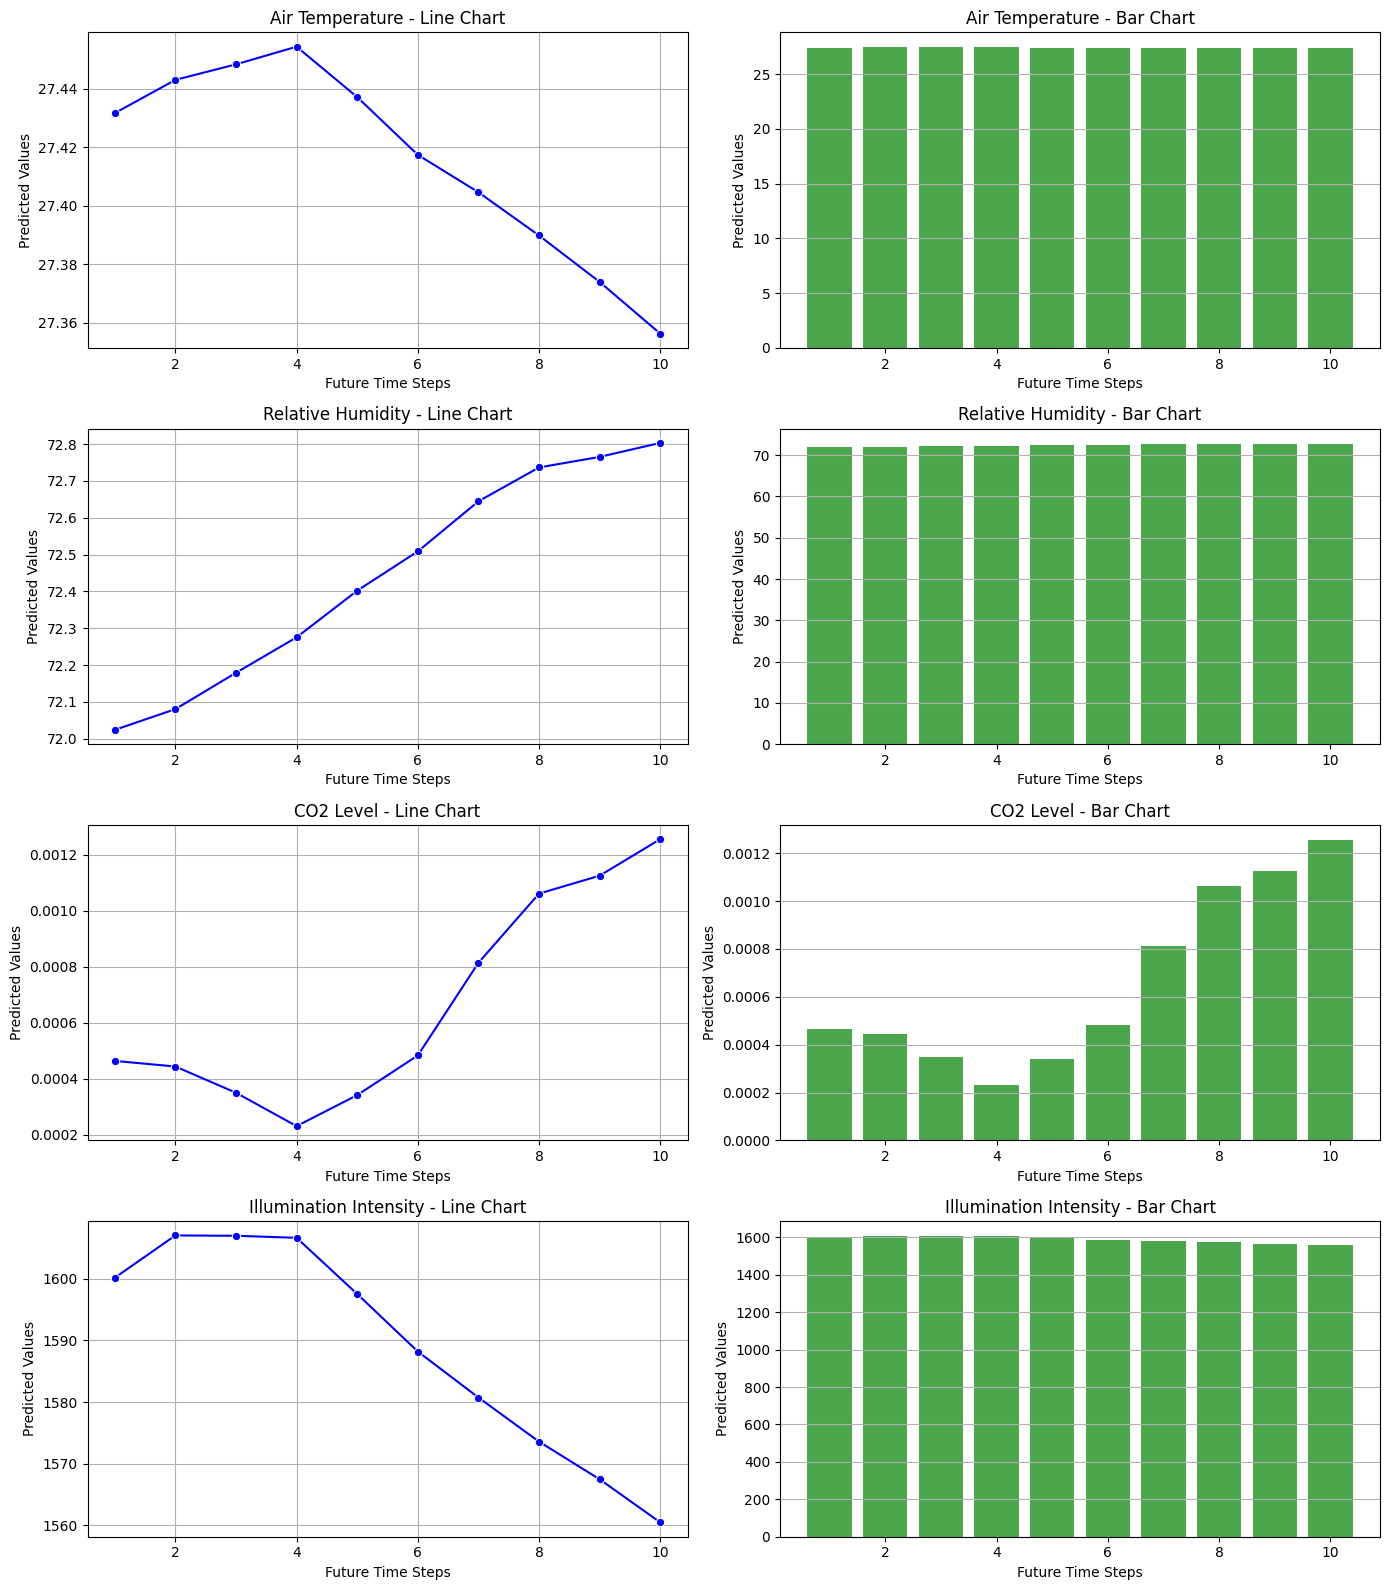

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data (Replace with your actual predictions)
time_steps = np.arange(1, len(future_predictions) + 1)

# Column names
labels = ["Air Temperature", "Relative Humidity", "CO2 Level", "Illumination Intensity"]

# Create subplots for 8 charts
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

for i in range(4):
    # Line Chart
    sns.lineplot(ax=axes[i, 0], x=time_steps, y=future_predictions[:, i], marker='o', color="b")
    axes[i, 0].set_title(f"{labels[i]} - Line Chart")
    axes[i, 0].set_xlabel("Future Time Steps")
    axes[i, 0].set_ylabel("Predicted Values")
    axes[i, 0].grid(True)

    # Bar Chart
    axes[i, 1].bar(time_steps, future_predictions[:, i], color="g", alpha=0.7)
    axes[i, 1].set_title(f"{labels[i]} - Bar Chart")
    axes[i, 1].set_xlabel("Future Time Steps")
    axes[i, 1].set_ylabel("Predicted Values")
    axes[i, 1].grid(axis="y")

# Adjust layout
plt.tight_layout()
plt.show()


## Water Bed

Epoch 1/150


<ipython-input-20-9d10dfe895e7>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-20-9d10dfe895e7>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.1761 - mae: 0.3134 - val_loss: 0.0537 - val_mae: 0.1913 - learning_rate: 0.0010
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0295 - mae: 0.1359 - val_loss: 0.0252 - val_mae: 0.1287 - learning_rate: 0.0010
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0211 - mae: 0.1127 - val_loss: 0.0366 - val_mae: 0.1499 - learning_rate: 0.0010
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0173 - mae: 0.1000 - val_loss: 0.0247 - val_mae: 0.1318 - learning_rate: 0.0010
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0124 - mae: 0.0879 - val_loss: 0.0194 - val_mae: 0.1115 - learning_rate: 0.0010
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0120 - mae: 0.0838 - val_loss: 0.0153 - val_mae: 0.0981 - learning_rate: 0.0010
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0120 - mae: 0.0799 - val_loss: 0.0138 - val_mae: 0.0943 - learning_rate: 0.0010
Epoch 8/150
8/8 ━━━━━━━━━━

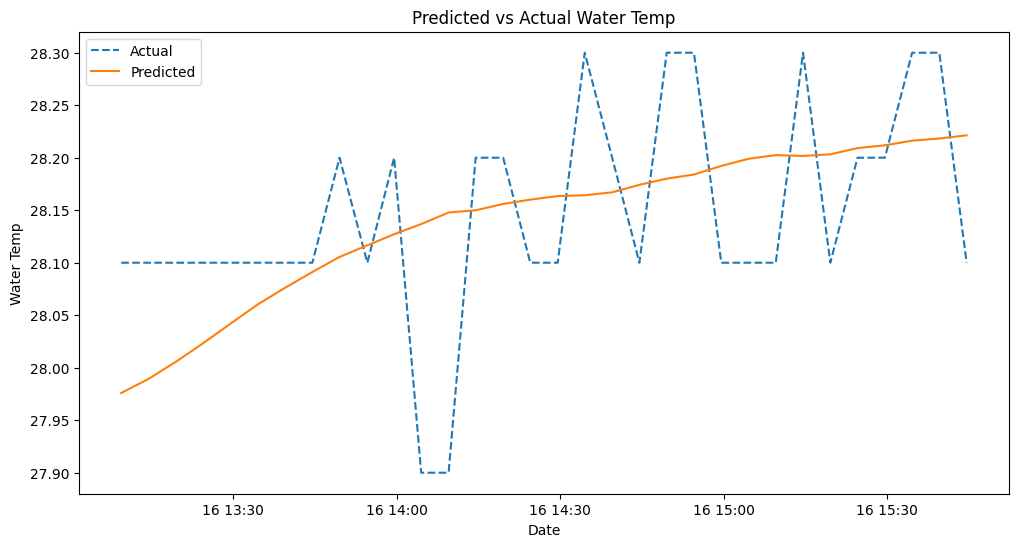


DO Level:
MAE: 0.4351
MSE: 0.2570
R² Score: 0.3771


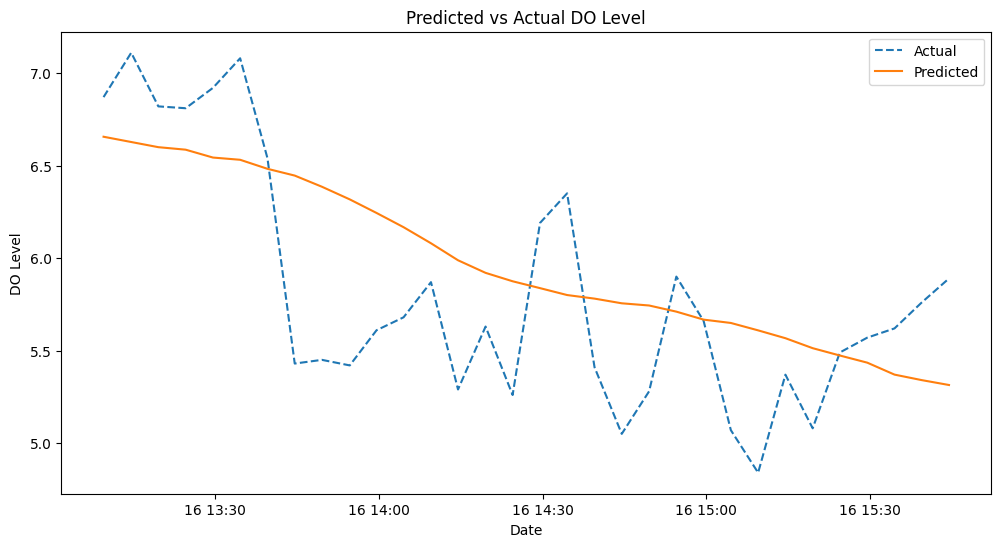


EC:
MAE: 2.7635
MSE: 10.8797
R² Score: -3.7227


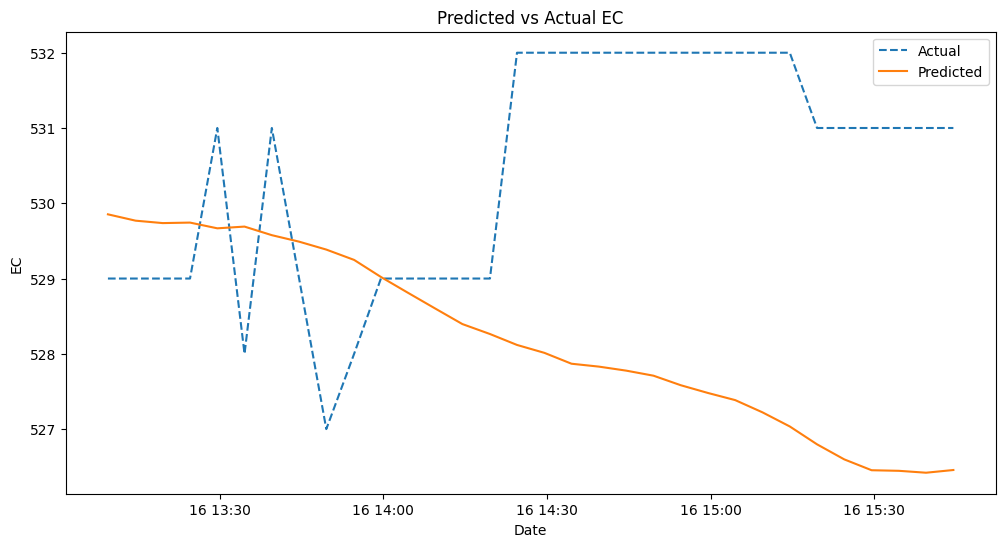


TDS:
MAE: 2.2443
MSE: 8.0417
R² Score: -5.0020


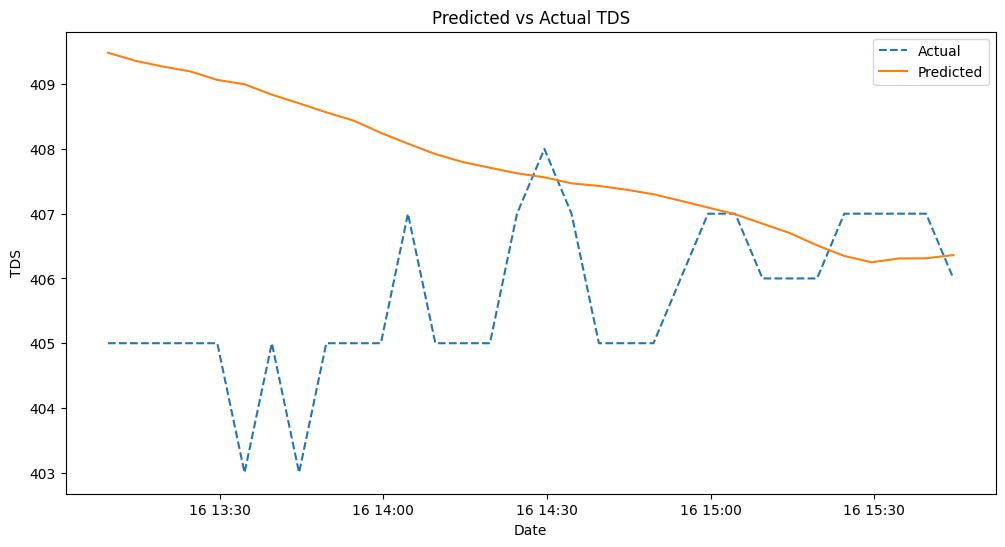


Nitrate:
MAE: 0.0241
MSE: 0.0009
R² Score: 0.0000


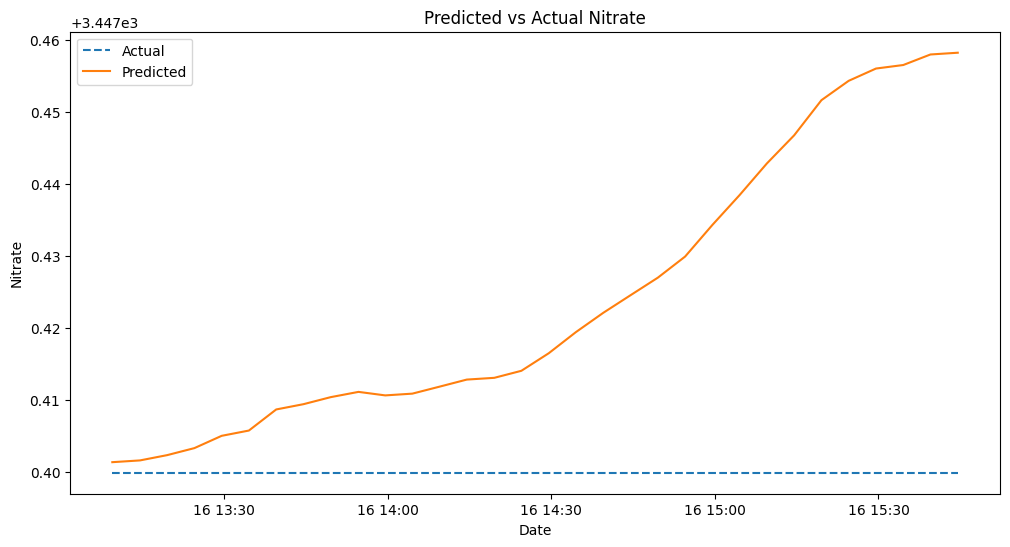


Nitrite:
MAE: 0.3618
MSE: 0.1574
R² Score: -0.4209


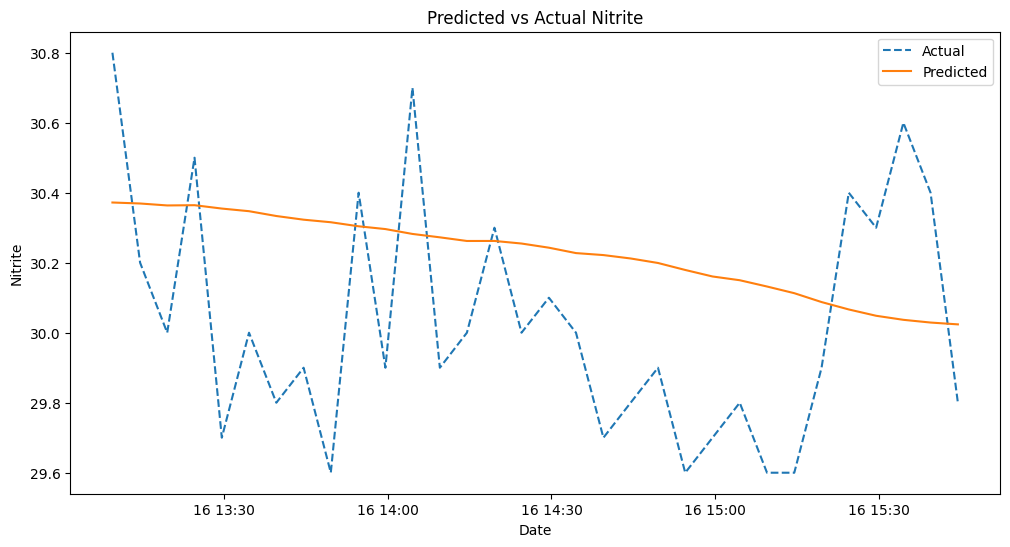


Ammonia:
MAE: 0.0236
MSE: 0.0006
R² Score: 0.0000


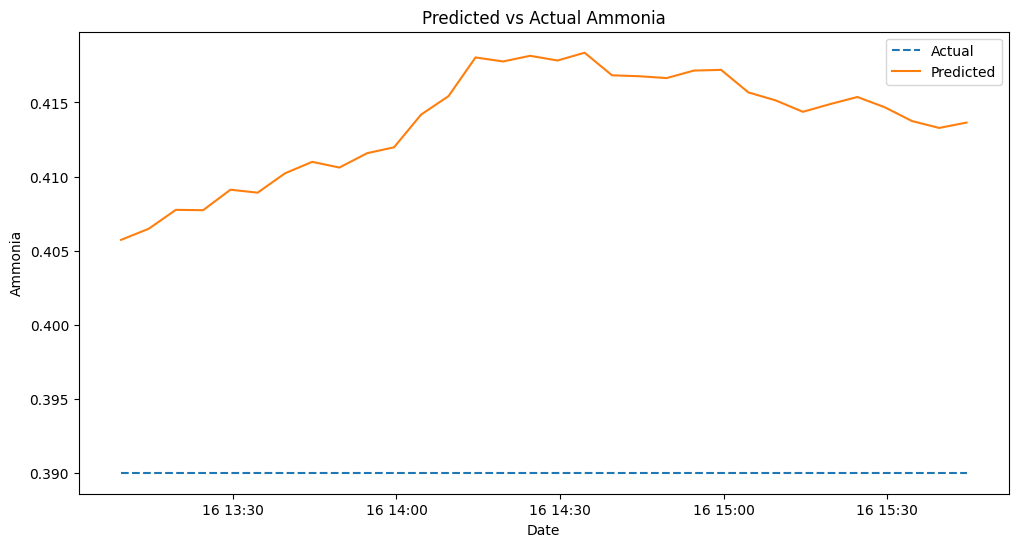


pH Level:
MAE: 0.0103
MSE: 0.0002
R² Score: 0.1753


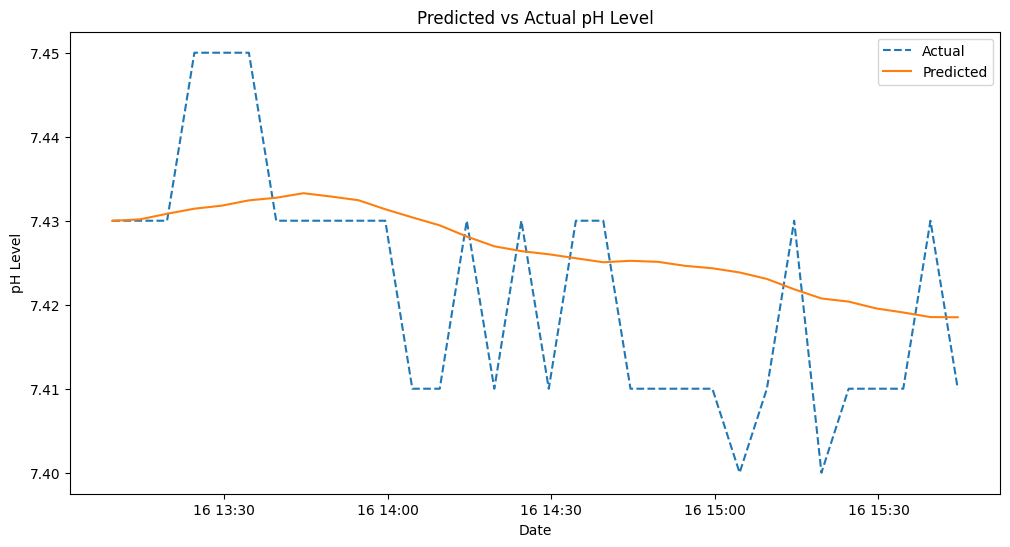

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load CSV file
def load_data(filename):
    df = pd.read_csv(filename, parse_dates=['created_at'], index_col='created_at')
    df = df[['water_temperature', 'dissolved_o2_level', 'electrical_conductivity', 'total_dissolved_solids', 'nitrate', 'nitrite', 'ammonia', 'ph_level']]

    # Handle missing values using both forward and backward fill
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Add rolling averages for trend awareness (Feature Engineering)
    for col in df.columns:
        df[f'{col}_rolling'] = df[col].rolling(window=5, min_periods=1).mean()

    df = df.sort_index()
    return df

# Preprocessing function
def preprocess_data(df):
    # Separate features and target variables
    X = df.iloc[:-1, :]
    y = df.iloc[1:, :8]  # Target is the first 8 columns (original features)

    # Fit scalers only on training data to prevent data leakage
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y)

    return X_scaled, y_scaled, X_scaler, y_scaler

# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Define improved LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(100, return_sequences=False)),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(8)  # Ensure the output layer has 8 neurons
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Main function
if __name__ == "__main__":
    # Load and preprocess data
    filename = "water_bed.csv"
    df = load_data(filename)
    X_scaled, y_scaled, X_scaler, y_scaler = preprocess_data(df)

    # Create sequences
    seq_length = 30
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

    # Train-test split (80-20 split)
    train_size = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    # Build and train LSTM model
    model = build_lstm_model((seq_length, X_seq.shape[2]))

    # Callbacks for better training
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)

    history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test),
                        callbacks=[early_stopping, lr_reduction])

    # Make predictions
    predictions = model.predict(X_test)
    predictions = y_scaler.inverse_transform(predictions)
    y_test_original = y_scaler.inverse_transform(y_test)

    # Calculate and display accuracy metrics
    categories = ['Water Temp', 'DO Level', 'EC', 'TDS', 'Nitrate', 'Nitrite', 'Ammonia', 'pH Level']
    for i, category in enumerate(categories):
        mae = mean_absolute_error(y_test_original[:, i], predictions[:, i])
        mse = mean_squared_error(y_test_original[:, i], predictions[:, i])
        r2 = r2_score(y_test_original[:, i], predictions[:, i])

        print(f"\n{category}:")
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"R² Score: {r2:.4f}")

        # Plot actual vs predicted values
        plt.figure(figsize=(12, 6))
        plt.plot(df.index[-len(predictions):], y_test_original[:, i], label='Actual', linestyle='dashed')
        plt.plot(df.index[-len(predictions):], predictions[:, i], label='Predicted', linestyle='solid')
        plt.xlabel('Date')
        plt.ylabel(category)
        plt.title(f'Predicted vs Actual {category}')
        plt.legend()
        plt.show()


## Sensors


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

# Sample Sensor Data (Replace with SQL or CSV input)
data = {
    "sensor_id": [101, 102, 103, 104, 105],
    "sensor_type": ["pH", "EC", "DO", "ORP", "TDS"],
    "expected_value": [6.5, 1.8, 8.5, 400, 500],  # Reference values
    "last_reading": [6.9, 2.1, 7.8, 380, 520],  # Latest sensor readings
    "date_latest_maintained": [
        "2024-01-01", "2024-01-10", "2024-02-05", "2024-02-20", "2024-03-01"
    ],
    "last_send_data": [
        "2024-03-10", "2024-03-12", "2024-02-28", "2024-03-15", "2024-03-14"
    ],
}

# Convert to DataFrame
df = pd.DataFrame(data)
df["date_latest_maintained"] = pd.to_datetime(df["date_latest_maintained"])
df["last_send_data"] = pd.to_datetime(df["last_send_data"])

# Error Percentage Calculation
df["error_percentage"] = abs(df["last_reading"] - df["expected_value"]) / df["expected_value"] * 100

# Define Calibration Threshold (5% for pH, 10% for others)
df["needs_calibration"] = df.apply(
    lambda row: row["error_percentage"] > (5 if row["sensor_type"] == "pH" else 10),
    axis=1,
)

# Days Since Last Maintenance
df["days_since_last_maintenance"] = (datetime.now() - df["date_latest_maintained"]).dt.days

# Days Since Last Data Transmission
df["days_since_last_send"] = (datetime.now() - df["last_send_data"]).dt.days

# Flag Sensors That Haven't Sent Data for More Than 7 Days
df["sensor_inactive"] = df["days_since_last_send"] > 7

# Predict Next Maintenance Date using Linear Regression
X = df["days_since_last_maintenance"].values.reshape(-1, 1)
y = df["error_percentage"].values.reshape(-1, 1)
model = LinearRegression().fit(X, y)
predicted_days = model.predict([[10]])[0][0]  # Prediction after 10 more days

# Visualization: Error Trends
plt.figure(figsize=(8, 5))
plt.bar(df["sensor_type"], df["error_percentage"],
        color=["red" if x else "green" for x in df["needs_calibration"]])
plt.axhline(y=5, color='gray', linestyle='--', label="pH Threshold (5%)")
plt.axhline(y=10, color='blue', linestyle='--', label="Other Threshold (10%)")
plt.xlabel("Sensor Type")
plt.ylabel("Error Percentage")
plt.title("Sensor Error Analysis")
plt.legend()
plt.show()

# Output Summary
print("\n📌 Sensor Status Summary:")
print(df[["sensor_id", "sensor_type", "error_percentage", "needs_calibration",
         "days_since_last_maintenance", "days_since_last_send", "sensor_inactive"]])

print(f"\n🔍 Predicted error percentage after 10 days: {predicted_days:.2f}%")

# Flagging Inactive Sensors
inactive_sensors = df[df["sensor_inactive"]]
if not inactive_sensors.empty:
    print("\n🚨 Alert: The following sensors have not sent data in the last 7 days:")
    print(inactive_sensors[["sensor_id", "sensor_type", "days_since_last_send"]])


# 📌 Sensor Status Summary:

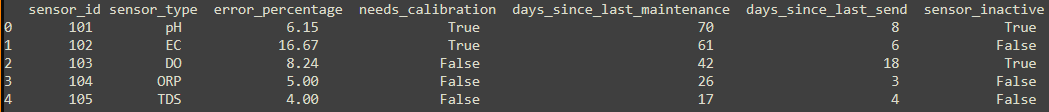


# 🔍 Predicted error percentage after 10 days: 12.34%

## 🚨 Alert: The following sensors have not sent data in the last 7 days:
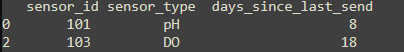
